In [20]:
import os

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numpy.lib.stride_tricks import sliding_window_view   
import optuna

In [4]:
from one.generator.univariate import UnivariateDataGenerator
from one.models import *
from one.utils import *
from one.scorer.pot import *

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
plt.rcParams["figure.figsize"] = 40,10
plt.rcParams["font.size"] = 15

# Load NASA Dataset

In [21]:
TRAIN = "../data/nasa/train/"
TEST = "../data/nasa/test/"
LABELS = "../data/nasa/labeled_anomalies.csv"

In [22]:
import ast
def convert_class(x):
    x = x.replace("contextual", "\"contextual\"")
    x = x.replace("point", "\"point\"")
    return x

def make_array(row):
    return np.array(row)

converters = {
    "anomaly_sequences": lambda x: make_array(ast.literal_eval(x)),
    "class": lambda x: ast.literal_eval(convert_class(x))
}


label_df = pd.read_csv(LABELS, converters=converters)

# get only those with multiple anomalies
label_df = label_df[label_df["anomaly_sequences"].apply(lambda x: x.shape[0]) > 1]
label_df = label_df.reset_index(drop=True)

In [23]:
label_df

,chan_id,spacecraft,anomaly_sequences,class,num_values
0,P-1,SMAP,"[[2149, 2349], [4536, 4844], [3539, 3779]]","[contextual, contextual, contextual]",8505
1,E-1,SMAP,"[[5000, 5030], [5610, 6086]]","[contextual, contextual]",8516
2,E-10,SMAP,"[[5000, 5050], [5601, 5871]]","[contextual, contextual]",8505
3,E-11,SMAP,"[[5000, 5050], [5614, 5857]]","[contextual, contextual]",8514
4,E-12,SMAP,"[[5610, 6141], [5000, 5050]]","[contextual, contextual]",8512
5,E-13,SMAP,"[[5309, 5410], [5600, 5640], [6449, 6569]]","[contextual, contextual, contextual]",8640
6,P-4,SMAP,"[[950, 1080], [2150, 2350], [4770, 4880]]","[point, point, point]",7783
7,T-1,SMAP,"[[2399, 3898], [6550, 6585]]","[point, contextual]",8612
8,T-3,SMAP,"[[2098, 2180], [5200, 5300]]","[point, point]",8579
9,G-7,SMAP,"[[3650, 3750], [5050, 5100], [7560, 7675]]","[contextual, point, contextual]",8029


In [24]:
train=[]
for root, _, files in os.walk(TRAIN):
    for file in files:
        if file.split(".")[0] in label_df["chan_id"].values:
             train.append(os.path.join(root, file))
                
test=[]
for root, _, files in os.walk(TEST):
    for file in files:
        if file.split(".")[0] in label_df["chan_id"].values:
             test.append(os.path.join(root, file))
                
                
file_list = list(zip(train, test))

## Get Labels

In [25]:
data_labels = {}

for idx, rng in enumerate(label_df["anomaly_sequences"].values):
    name = label_df.iloc[idx, 0]
    test_arr = np.load(f"{TEST}{name}.npy")
    
    label = np.zeros(len(test_arr))
    
    for start, end in rng:
        label[start:end] = 1
    
    data_labels.update({name: label})

# Visualize

In [ ]:
for train, test in file_list:
    train_arr = np.load(train)
    test_arr = np.load(test)
    data = np.vstack((train_arr, test_arr))
    name = train.split("/")[-1].split(".")[0]
    print(f"{name} {'#'*30}")
    
    
    plt.rcParams["figure.figsize"] = 40, 1 * data.shape[1]
    plt.rcParams["font.size"] = 15

    
    fig, axes = plt.subplots(data.shape[1])
    axes[0].set_title(name)

    for idx, d in enumerate(data.T):
        axes[idx].plot(d)
        
    labels = label_df[label_df["chan_id"] == name]["anomaly_sequences"].values[0]
    for start, end in labels:
        start += len(train_arr)
        end += len(train_arr)
        
        for ax in axes:
            ax.axvspan(start, end, alpha=0.5, color='red')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            


    axes[-1].get_xaxis().set_visible(True)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

# Scoring Helper

In [13]:
class ScoreCounter:
    def __init__(self, delay: int=None):
        self.tp = 0
        self.fp = 0
        self.tn = 0
        self.fn = 0
        
        self.delay = delay
        
        self.point_anom_total = 0
        self.point_anom_correct = 0
        
        self.contextual_anom_total = 0
        self.contextual_anom_correct = 0
        
    def process(self, preds, labels, types):
        preds = preds.copy()
        labels = labels.copy()
        
        ground_truth_ones = np.where(labels == 1)[0]
        pred_ones = np.where(preds == 1)[0]
        ranges = self._consecutive(ground_truth_ones)
        
        tp, fp, tn, fn = 0, 0, 0, 0
        
        for idx, r in enumerate(ranges):
            intersect = np.intersect1d(r, pred_ones, assume_unique=True)
            # if alert delay more than 100 timesteps, count that as bad!
            
            if types[idx] == "point": self.point_anom_total += 1
            else: self.contextual_anom_total += 1
               
            if intersect.size != 0:
                cond = intersect[0] < r[0] + self.delay if self.delay is not None else True
                if cond:
                    tp += r.size
                    if types[idx] == "point": self.point_anom_correct += 1
                    else: self.contextual_anom_correct += 1
                else:
                    fn += r.size
 
                preds[intersect] = 0
                pred_ones = np.where(preds == 1)[0]
            else:
                fn += r.size
            
        fp += pred_ones.size
        tn += preds.size - tp - fp - fn
        
        self.tp += tp
        self.fp += fp
        self.tn += tn
        self.fn += fn
        
        
        return
        
        
    def _consecutive(self, data, stepsize=1):
        return np.split(data, np.where(np.diff(data) != stepsize)[0]+1)
    
    
    @property
    def tpr(self):
        return self.tp/(self.fn+self.tp)
    
    @property
    def fpr(self):
        return self.fp/(self.tn+self.fp)
    
    @property
    def tnr(self):
        return self.tn/(self.tn+self.fp)
        
    @property
    def fnr(self):
        return self.fn/(self.fn+self.tp)
        
    @property
    def precision(self):
        if self.tp+self.fp == 0: return 0
        return self.tp/(self.tp+self.fp)
    
    @property
    def recall(self):
        if self.tp+self.fn == 0: return 0
        return self.tp/(self.tp+self.fn)
    
    @property
    def f1(self):
        if self.recall + self.precision == 0: return 0
        return (2*self.precision*self.recall)/(self.precision+self.recall)
    
    @property
    def point_correct(self):
        if self.point_anom_total == 0: return 0
        return self.point_anom_correct/self.point_anom_total
    
    @property
    def contextual_correct(self):
        if self.contextual_anom_total == 0: return 0
        return self.contextual_anom_correct/self.contextual_anom_total
    
    def __str__(self):
        return f"{scorer.tp}, {scorer.fp}, {scorer.tn}, {scorer.fn}, {scorer.tpr}, {scorer.fpr}, {scorer.tnr}, {scorer.fnr}, {scorer.precision}, {scorer.recall}, {scorer.f1}, {scorer.point_correct}, {scorer.contextual_correct}"
    
    

In [ ]:
labels = np.append(np.zeros(20), np.full(20, 1))

In [ ]:
pred = np.append(np.zeros(30), np.full(10, 1))
pred[10] = 1

In [ ]:
tp = 0
fp = 1
tn = 19
fn = 20

scorer = ScoreCounter(delay=5)
scorer.process(pred, labels, ["point"])

assert tp == scorer.tp
assert fp == scorer.fp
assert tn == scorer.tn
assert fn == scorer.fn

# Run Experiments

## Untuned Baseline

### Setup

In [15]:
SAVE_DIR = "../results/multivar-nasa/untuned/"

In [16]:
DELAY = 50

### Single-variate Ensemble

#### MA

In [ ]:
# Moving Average Model
model_name = "ma"

scorer = ScoreCounter(delay=DELAY)
for train, test in file_list:
    name = train.split("/")[-1].split(".")[0]
    
    train = np.load(train)
    test = np.load(test)
    labels = data_labels[name]
    types = label_df.loc[label_df["chan_id"]==name]["class"].values[0]
    
    params = {
        "window": 50
    }
    
    window = params["window"]
    model = MovingAverageModel(window)
    test_extend = np.concatenate((train[-window:], test))
    
    scores = []
    preds = []
    for series in test_extend.T:
        score = np.abs(model.get_scores(series)[window:])
        scores.append(score)

        # Get threshold (Not needed for Quantile)
        thres = pot(score, 1e-2, 0.95)

        pred = score.copy()
        pred[pred <= thres] = 0
        pred[pred > thres] = 1

        preds.append(pred)

    scores = np.array(scores).T    
    preds = np.any(preds, axis=0)

    save = f"{SAVE_DIR}{model_name}/{name}"
    os.makedirs(SAVE_DIR+model_name, exist_ok=True)
    np.savetxt(save+"-scores.txt", scores, header=str(params))
    np.savetxt(save+"-preds.txt", preds, header=str(params))

    scorer.process(preds, labels, types)

print(scorer)

#### Quantile

In [ ]:
model_name = "quantile"

scorer = ScoreCounter(delay=DELAY)
for train, test in file_list:
    name = train.split("/")[-1].split(".")[0]
    
    train = np.load(train)
    test = np.load(test)
    labels = data_labels[name]
    types = label_df.loc[label_df["chan_id"]==name]["class"].values[0]
    
    params = {
        "window": 50
    }
    
    window = params["window"]
    model = QuantileModel(window)
    test_extend = np.concatenate((train[-window:], test))

    scores = []
    preds = []
    for series in test_extend.T:
        score = model.get_scores(series)[window:]
        scores.append(score)

        # Get threshold (Not needed for Quantile)
        """
        thres = pot(score, 1e-2, 0.95)

        pred = score.copy()
        pred[pred <= thres] = 0
        pred[pred > thres] = 1

        preds.append(pred)
        """
        preds.append(score)

    scores = np.array(scores).T
    preds = np.any(preds, axis=0)

    save = f"{SAVE_DIR}{model_name}/{name}"
    os.makedirs(SAVE_DIR+model_name, exist_ok=True)
    np.savetxt(save+"-scores.txt", scores, header=str(params))
    np.savetxt(save+"-preds.txt", preds, header=str(params))

    scorer.process(preds, labels, types)

print(scorer)

#### Regression

In [ ]:
import warnings
warnings.filterwarnings('ignore')


model_name = "regression"

scorer = ScoreCounter(delay=DELAY)
for train, test in file_list:
    name = train.split("/")[-1].split(".")[0]
    
    train = np.load(train)
    test = np.load(test)
    labels = data_labels[name]
    types = label_df.loc[label_df["chan_id"]==name]["class"].values[0]
    
    params = {
        "window": 50
    }
    
    window = params["window"]
    model = RegressionModel(window)
    test_extend = np.concatenate((train[-window:], test))

    scores = []
    preds = []
    for idx, series in enumerate(test_extend.T):
        model = RegressionModel(window)
        model.fit(train.T[idx])

        score = model.get_scores(series)[0].flatten()
        scores.append(score)

        # Get threshold (Not needed for Quantile)
        thres = pot(score, 1e-2, 0.95)

        pred = score.copy()
        pred[pred <= thres] = 0
        pred[pred > thres] = 1

        preds.append(pred)


    scores = np.array(scores).T
    preds = np.any(preds, axis=0)

    save = f"{SAVE_DIR}{model_name}/{name}"
    os.makedirs(SAVE_DIR+model_name, exist_ok=True)
    np.savetxt(save+"-scores.txt", scores, header=str(params))
    np.savetxt(save+"-preds.txt", preds, header=str(params))

    scorer.process(preds, labels, types)

print(scorer)



#### ARIMA

In [ ]:
"""
model_name = "arima"
scorer = ScoreCounter(delay=DELAY)

for train, test in file_list:
    name = train.split("/")[-1].split(".")[0]
    
    train = np.load(train)
    test = np.load(test)
    labels = data_labels[name]
    types = label_df.loc[label_df["chan_id"]==name]["class"].values[0]
    
    params = {
        "p": 1,
        "d": 1,
        "q": 2
    }
    
    test_extend = np.concatenate((train[-window:], test))

    preds = []
    for idx, series in enumerate(test_extend.T):
        model = ARIMAModel(params["p"], params["d"], params["q"])
        model.fit(train.T[idx])

        score = model.get_scores(series).flatten()[window:]

        # Get threshold (Not needed for Quantile)
        thres = pot(score, 1e-2, 0.95)

        pred = score.copy()
        pred[pred <= thres] = 0
        pred[pred > thres] = 1

        preds.append(pred)

    ind_preds = np.array(preds)    
    preds = np.any(preds, axis=0)
    
    save = f"{SAVE_DIR}{model_name}/{name}"
    os.makedirs(SAVE_DIR+model_name, exist_ok=True)
    np.savetxt(save+"-individual_preds.txt", ind_preds, header=str(params))
    np.savetxt(save+"-preds.txt", preds, header=str(params))

    scorer.process(preds, labels, types)

print(scorer)
"""

### Multivariate Native

#### IForest

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 


model_name = "iforest"
scorer = ScoreCounter(delay=DELAY)

for train, test in file_list:
    name = train.split("/")[-1].split(".")[0]
    
    train = np.load(train)
    test = np.load(test)
    labels = data_labels[name]
    types = label_df.loc[label_df["chan_id"]==name]["class"].values[0]
    
    params = {
        "window": 50,
    }
    window = params["window"]
    test_extend = np.concatenate((train[-window:], test))
    model = IsolationForestModel(window)
    model.fit(train)
    score = model.get_scores(test_extend).flatten()[window:]
    
    # Get threshold (Not needed for Quantile)
    thres = pot(score, 1e-2, 0.95)

    pred = score.copy()
    pred[pred <= thres] = 0
    pred[pred > thres] = 1
    


    save = f"{SAVE_DIR}{model_name}/{name}"
    os.makedirs(SAVE_DIR+model_name, exist_ok=True)
    np.savetxt(save+"-scores.txt", score, header=str(params))
    np.savetxt(save+"-preds.txt", pred, header=str(params))

    scorer.process(pred, labels, types)
print(scorer)

#### NBEATS

In [ ]:
%%capture
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 


model_name = "nbeats"
scorer = ScoreCounter(delay=DELAY)

for train, test in file_list:
    name = train.split("/")[-1].split(".")[0]

    train = np.load(train)
    test = np.load(test)
    labels = data_labels[name]
    types = label_df.loc[label_df["chan_id"]==name]["class"].values[0]

    params = {
        "window": 50,
    }

    window = params["window"]
    test_extend = np.concatenate((train[-window:], test))
    model = NBEATSModel(window, use_gpu=True)
    model.fit(train)
    score = model.get_scores(test_extend)[0].flatten()
    res = model.get_scores(test_extend)[1]
    
    assert len(score) == len(labels)

    # Get threshold (Not needed for Quantile)
    thres = pot(score, 1e-2, 0.95)

    pred = score.copy()
    pred[pred <= thres] = 0
    pred[pred > thres] = 1



    save = f"{SAVE_DIR}{model_name}/{name}"
    os.makedirs(SAVE_DIR+model_name, exist_ok=True)
    np.savetxt(save+"-scores.txt", res, header=str(params))
    np.savetxt(save+"-preds.txt", pred, header=str(params))

    scorer.process(pred, labels, types)
print(scorer)

#### NHiTS

In [ ]:
%%capture
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 


model_name = "nhits"
scorer = ScoreCounter(delay=DELAY)

for train, test in file_list:
    name = train.split("/")[-1].split(".")[0]

    train = np.load(train)
    test = np.load(test)
    labels = data_labels[name]
    types = label_df.loc[label_df["chan_id"]==name]["class"].values[0]

    params = {
        "window": 50,
    }

    window = params["window"]
    test_extend = np.concatenate((train[-window:], test))
    model = NHiTSModel(window, use_gpu=True)
    model.fit(train)
    score = model.get_scores(test_extend)[0].flatten()
    res = model.get_scores(test_extend)[1]
    
    assert len(score) == len(labels)

    # Get threshold (Not needed for Quantile)
    thres = pot(score, 1e-2, 0.95)

    pred = score.copy()
    pred[pred <= thres] = 0
    pred[pred > thres] = 1



    save = f"{SAVE_DIR}{model_name}/{name}"
    os.makedirs(SAVE_DIR+model_name, exist_ok=True)
    np.savetxt(save+"-scores.txt", res, header=str(params))
    np.savetxt(save+"-preds.txt", pred, header=str(params))

    scorer.process(pred, labels, types)
print(scorer)

#### RNN-GRU

In [ ]:
%%capture
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 


model_name = "rnn_gru"
scorer = ScoreCounter(delay=DELAY)

for train, test in file_list:
    name = train.split("/")[-1].split(".")[0]

    train = np.load(train)
    test = np.load(test)
    labels = data_labels[name]
    types = label_df.loc[label_df["chan_id"]==name]["class"].values[0]

    params = {
        "window": 50,
    }

    window = params["window"]
    test_extend = np.concatenate((train[-window:], test))
    model = RNNModel(window, use_gpu=True, rnn_model="GRU")
    model.fit(train)
    score = model.get_scores(test_extend)[0].flatten()
    res = model.get_scores(test_extend)[1]
    
    assert len(score) == len(labels)

    # Get threshold (Not needed for Quantile)
    thres = pot(score, 1e-2, 0.95)

    pred = score.copy()
    pred[pred <= thres] = 0
    pred[pred > thres] = 1



    save = f"{SAVE_DIR}{model_name}/{name}"
    os.makedirs(SAVE_DIR+model_name, exist_ok=True)
    np.savetxt(save+"-scores.txt", res, header=str(params))
    np.savetxt(save+"-preds.txt", pred, header=str(params))

    scorer.process(pred, labels, types)
print(scorer)

#### TCN

In [ ]:
%%capture
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 


model_name = "tcn"
scorer = ScoreCounter(delay=DELAY)

for train, test in file_list:
    name = train.split("/")[-1].split(".")[0]

    train = np.load(train)
    test = np.load(test)
    labels = data_labels[name]
    types = label_df.loc[label_df["chan_id"]==name]["class"].values[0]

    params = {
        "window": 50,
    }

    window = params["window"]
    test_extend = np.concatenate((train[-window:], test))
    model = TCNModel(window, use_gpu=True)
    # EPOCHS = 30
    model.fit(train)
    model.fit(train)
    score = model.get_scores(test_extend)[0].flatten()
    res = model.get_scores(test_extend)[1]
    
    assert len(score) == len(labels)

    # Get threshold (Not needed for Quantile)
    thres = pot(score, 1e-2, 0.95)

    pred = score.copy()
    pred[pred <= thres] = 0
    pred[pred > thres] = 1



    save = f"{SAVE_DIR}{model_name}/{name}"
    os.makedirs(SAVE_DIR+model_name, exist_ok=True)
    np.savetxt(save+"-scores.txt", res, header=str(params))
    np.savetxt(save+"-preds.txt", pred, header=str(params))

    scorer.process(pred, labels, types)
print(scorer)

#### Transformer

In [ ]:
%%capture
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 


model_name = "transformer"
scorer = ScoreCounter(delay=DELAY)

for train, test in file_list:
    name = train.split("/")[-1].split(".")[0]

    train = np.load(train)
    test = np.load(test)
    labels = data_labels[name]
    types = label_df.loc[label_df["chan_id"]==name]["class"].values[0]

    params = {
        "window": 50,
    }

    window = params["window"]
    test_extend = np.concatenate((train[-window:], test))
    model = TransformerModel(window, use_gpu=True)
    # EPOCHS = 30
    model.fit(train)
    model.fit(train)
    score = model.get_scores(test_extend)[0].flatten()
    res = model.get_scores(test_extend)[1]
    
    assert len(score) == len(labels)

    # Get threshold (Not needed for Quantile)
    thres = pot(score, 1e-2, 0.95)

    pred = score.copy()
    pred[pred <= thres] = 0
    pred[pred > thres] = 1



    save = f"{SAVE_DIR}{model_name}/{name}"
    os.makedirs(SAVE_DIR+model_name, exist_ok=True)
    np.savetxt(save+"-scores.txt", res, header=str(params))
    np.savetxt(save+"-preds.txt", pred, header=str(params))

    scorer.process(pred, labels, types)
print(scorer)

#### TranAD

In [ ]:
# %%capture
# import warnings
# warnings.filterwarnings("ignore", category=RuntimeWarning) 


model_name = "tranad"
scorer = ScoreCounter(delay=DELAY)

for train, test in file_list:
    name = train.split("/")[-1].split(".")[0]

    train = np.load(train)
    test = np.load(test)
    labels = data_labels[name]
    types = label_df.loc[label_df["chan_id"]==name]["class"].values[0]
    
    params = {
        "window": 50,
    }

    window = params["window"]
    
    test_extend = np.concatenate((train[-window:], test))
    
    model = TranADModel(window, use_gpu=True)
    model.fit(train)
    scores = model.get_scores(test_extend)[window:]
    

    # Get threshold (Not needed for Quantile)
    score = scores.sum(axis=1)
    thres = pot(score, 1e-2, 0.95)

    pred = score.copy()
    pred[pred <= thres] = 0
    pred[pred > thres] = 1

    save = f"{SAVE_DIR}{model_name}/{name}"
    os.makedirs(SAVE_DIR+model_name, exist_ok=True)
    np.savetxt(save+"-scores.txt", scores, header=str(params))
    np.savetxt(save+"-preds.txt", pred, header=str(params))

    scorer.process(pred, labels, types)
    
print(scorer)

#### FluxEV

#### FluxEV

# Load Results

## Untuned

In [63]:
method = "rnn_gru"

#######################
SAVE_DIR = "../results/multivar-nasa/untuned/"
method += "/"
l = [i for i in get_files_from_path(SAVE_DIR+method) if "scores" not in i]
scorer = ScoreCounter(delay=DELAY)
for f in l:
    name = "-".join(f.split("-")[:2])
    idx = [name in i[0] for i in file_list].index(True)
    
    path = file_list[idx][1]
    data = np.load(path)
    preds = np.loadtxt(SAVE_DIR+method+f)
    label = data_labels[name][-len(preds):]
    types = label_df.loc[label_df["chan_id"]==name]["class"].values[0]
    
    
    scorer.process(preds, label, types)
    
print(scorer)

1594, 1479, 51524, 1548, 0.5073201782304265, 0.027904080901081072, 0.9720959190989189, 0.49267982176957353, 0.5187113569801497, 0.5073201782304265, 0.5129525341914724, 0.2, 0.46153846153846156


## F1 - 50%

In [ ]:
method = "regression"

#######################
SAVE_DIR = "../results/multivar-nasa/f1tuned-1anom/"
method += "/"
l = [i for i in get_files_from_path(SAVE_DIR+method) if "scores" not in i]
scorer = ScoreCounter(delay=DELAY)
for f in l:
    name = "-".join(f.split("-")[:2])
    idx = [name in i[0] for i in file_list].index(True)
    
    path = file_list[idx][1]
    data = np.load(path)
    label = data_labels[name]
    types = label_df.loc[label_df["chan_id"]==name]["class"].values[0]
    
    preds = np.loadtxt(SAVE_DIR+method+f)
    
    scorer.process(preds, label, types)
    
print(scorer)

# Fix Results

## Untuned

In [141]:
import json
method = "quantile"

#######################
SAVE_DIR = "../results/multivar-nasa/f1tuned-1anom/"
method += "/"
l = [i for i in get_files_from_path(SAVE_DIR+method) if "scores" not in i]
scorer = ScoreCounter(delay=DELAY)
for f in l:
    name = "-".join(f.split("-")[:2])
    tune_len = label_df.loc[label_df["chan_id"]==name]["anomaly_sequences"].values[0][0][1] + 1
    idx = [name in i[0] for i in file_list].index(True)
    
    path = file_list[idx][1]
    data = np.load(path)
    label = data_labels[name][tune_len:]
    types = label_df.loc[label_df["chan_id"]==name]["class"].values[0][0:]
    
    scores = np.loadtxt(SAVE_DIR+method+f.replace("preds", "scores"))[tune_len:]
    preds = np.loadtxt(SAVE_DIR+method+f)[tune_len:]
   
    with open(SAVE_DIR+f"{method}"+f.replace("preds", "scores")) as file:
        params = file.readline()

    if "#" not in params: print("need to be redone"); break

    params = params.replace("# ", "")
    params = params.replace("'", '"')
    params = json.loads(params)

    save = f"{SAVE_DIR}{method.replace('/','')}/{name}"
    np.savetxt(save+"-scores.txt", scores, header=str(params))
    np.savetxt(save+"-preds.txt", preds, header=str(params))
    
    scorer.process(preds, label, types)
    
    
print(scorer)

2977, 7927, 45076, 165, 0.9474856779121579, 0.14955757221289362, 0.8504424277871064, 0.05251432208784214, 0.27301907556859867, 0.9474856779121579, 0.4238929232521714, 0.8, 0.8461538461538461


In [68]:
arr = np.random.random(size=(100,2))

In [71]:
pot(arr, 1e-02, )

0.9937401669458378

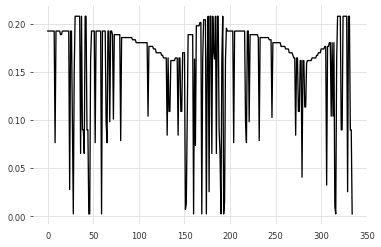

In [110]:
plt.plot(scores_test)